In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys

import pytoolsAL as ptAL

sys.path.append('../src')

pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'


In [2]:
mn = 'ZYE_0069'
td = '2023-07-17'
ca_en = '1'

expRoot = Path(r'Z:\Subjects\ZYE_0069\2023-07-17\1')

galvoX = np.squeeze(np.load(expRoot/'galvoXPositions.npy'))
galvoY = np.squeeze(np.load(expRoot/'galvoYPositions.npy'))
laserPowers = np.squeeze(np.load(expRoot/'laserPowers.npy'))
print(len(laserPowers))
laserOn = np.squeeze(np.load(expRoot/'laserOnTimes.npy'))
laserOff = np.squeeze(np.load(expRoot/'laserOffTimes.npy'))
frameTimes = np.squeeze(np.load(expRoot/'cameraFrameTimes.npy'))[::2]

667


In [3]:
svdTemp = np.load(expRoot/'corr/svdTemporalComponents_corr.npy')
svdSpatFull = np.load(expRoot/'blue/svdSpatialComponents.npy')[:, :, :500]
px, py, ncomps = svdSpatFull.shape
svdSpat = svdSpatFull.reshape(px*py, ncomps)
tToWf = scipy.interpolate.interp1d(frameTimes, svdTemp, axis=0, fill_value='extrapolate')

In [4]:
exp1 = np.r_[:334]
exp2 = np.r_[334:len(laserPowers)]

In [5]:
savedir = Path(r'Z:\Subjects\ZYE_0069\2023-07-17\2')

powers = np.unique(laserPowers[exp1])
trsPowers = []
n_samples = 500
hemi = 'right'
for iP, power in enumerate(powers):
    thesePowers = np.argwhere(laserPowers[exp1] == power).ravel()
    if hemi == 'left':
        galv = 0
    elif hemi == 'right':
        galv = 3.3
        
    thesePos = np.argwhere(galvoX[exp1] == galv).ravel()
    theseTrs = np.intersect1d(thesePowers, thesePos)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-0.3+on, 1+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(tToWf(trs), axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat @ dwf
    mov = mov.reshape(px, py, -1)
    
    trsPowers.append(mov.transpose(2, 0, 1))
    
trsPowers = np.array(trsPowers)

FileNotFoundError: [WinError 2] The system cannot find the file specified

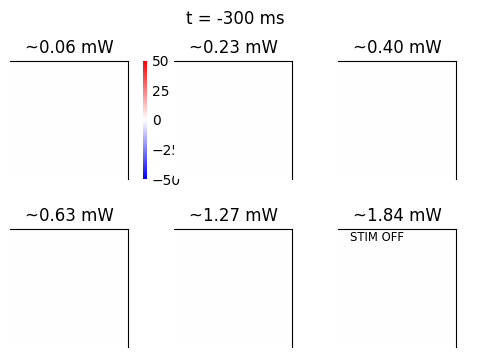

In [6]:
f = plt.figure(figsize=(6, 4))
gs = mpl.gridspec.GridSpec(2, 3)

timestamps = np.linspace(-0.3, 1, n_samples)*1000
stimOn = np.intersect1d(np.argwhere(timestamps > 0).ravel(), np.argwhere(timestamps < 100).ravel())

images = []
axes = []

for pwr in range(6):
    ax = plt.subplot(gs[pwr])
    im = plt.imshow(np.zeros((px, py)), clim=np.r_[-1, 1]*50, cmap='bwr', animated=True)
    ax = ptAL.plotting.apply_image_defaults(ax)
    stext = plt.text(0.1, 0.9, '', fontsize='small', transform=ax.transAxes, zorder=20)
    plt.title(f'~{powers[pwr]/3.3*1.9:.2f} mW')
    
    axes.append(ax)
    if pwr == 0:
        cb = ptAL.plotting.add_colorbar(ax)
    else:
        cb = ptAL.plotting.add_colorbar_space(ax)
    
    images.append(im)

def animate(i):
    for pwr in range(6):
        images[pwr].set_array(trsPowers[pwr, i])
        f.suptitle(f't = {timestamps[i]:.0f} ms')
        if np.isin(i, stimOn):
            stext.set_text('STIM ON')
            stext.set_color('red')
        else:
            stext.set_text('STIM OFF')
            stext.set_color('k')
        
    # if timestamps[i] <= 0 and timestamps[i] <= 0.1:
    #     plt.text(0.1, 0.9, 'STIM ON', c='red', transform=ax.transAxes)
    
anim = mpl.animation.FuncAnimation(f, animate, frames=n_samples-1, cache_frame_data=False, interval=250)

savepath = savedir / f'{hemi}_power.avi'
ptAL.plotting.anim_to_file(anim, str(savepath), rewrite=True, fps=25, bitrate=-1)
ptAL.image.avi_to_gif(str(savepath), fps=4)

clear_output()
# plt.show()

In [ ]:
trials.shape

In [ ]:
plt.imshow(np.mean(trials, axis=0)[100:200])

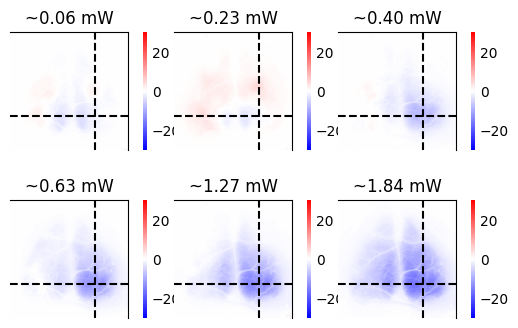

In [7]:
f = plt.figure(figsize=(6, 4))
gs = mpl.gridspec.GridSpec(2, 3)

hline = 400
vline = 400

lkwargs = {'color': 'k', 'ls': 'dashed'}
for i in range(6):
    trials = trsPowers[i, stimOn[:50]]
    ax = plt.subplot(gs[i])
    plt.imshow(np.mean(trials, axis=0), cmap='bwr', clim=np.r_[-1, 1]*30)
    ax = ptAL.plotting.apply_image_defaults(ax)
    plt.title(f'~{powers[i]/3.3*1.9:.2f} mW')
    
    plt.axhline(hline, **lkwargs)
    plt.axvline(vline, **lkwargs)
    cb = ptAL.plotting.add_colorbar(ax)

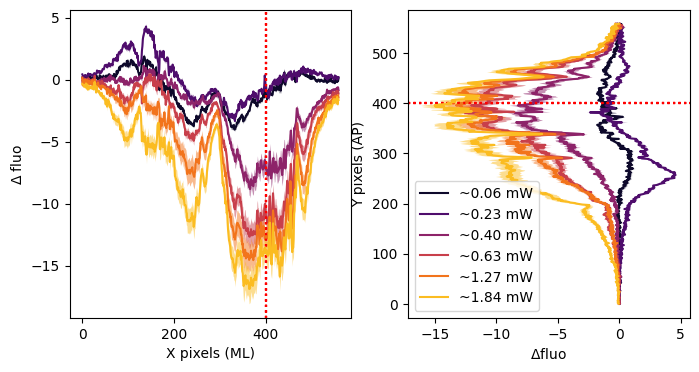

In [8]:
f = plt.figure(figsize=(8, 4))
gs = mpl.gridspec.GridSpec(1, 2)
ax = plt.subplot(gs[0])

cm = mpl.cm.ScalarMappable(cmap='inferno')
cm.set_clim(-0.5, 6)

for i in range(6):
    c = cm.to_rgba(i)
    trials = trsPowers[i, stimOn[:50]]
    line = trials[:, hline]
    plt.axvline(hline, c='red', ls=':')
    plt.plot(np.mean(line, axis=0), c=c)
    plt.fill_between(np.arange(px), np.mean(line, axis=0)+scipy.stats.sem(line, axis=0), 
                     np.mean(line, axis=0)-scipy.stats.sem(line, axis=0), color=c, lw=0, alpha=0.5)
plt.xlabel('X pixels (ML)')
plt.ylabel('$\Delta$ fluo')

ax = plt.subplot(gs[1])
for i in range(6):
    c = cm.to_rgba(i)
    trials = trsPowers[i, stimOn[:50]]
    line = trials[:, :, vline]
    plt.axhline(vline, c='red', ls=':')
    plt.plot(np.mean(line, axis=0), np.arange(px), label=f'~{powers[i]/3.3*1.9:.2f} mW', c=c)
    plt.fill_betweenx(np.arange(px), np.mean(line, axis=0)+scipy.stats.sem(line, axis=0), 
                 np.mean(line, axis=0)-scipy.stats.sem(line, axis=0), lw=0, alpha=0.5, color=c)
plt.ylabel('Y pixels (AP)')
plt.xlabel('$\Delta$fluo')
plt.legend()

In [ ]:
savedir = Path(r'Z:\Subjects\ZYE_0069\2023-07-17\2')

powers = np.unique(laserPowers[exp1])
trsPowers = []
n_samples = 500
for iP, power in enumerate(powers):
    theseTrs = np.argwhere(laserPowers[exp1] == power)
    onTimes = laserOn[theseTrs]
    trs = [np.linspace(-0.3+on, 2+on, n_samples) for on in onTimes]
    trs = np.squeeze(np.array(trs))
    
    wf = np.mean(tToWf(trs), axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
    dwf = np.array(dwf)
    mov = svdSpat @ dwf
    mov = mov.reshape(px, py, -1)
    
    trsPowers.append(mov.transpose(2, 0, 1))
    
trsPowers = np.array(trsPowers)